In [797]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [798]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from omegaconf import open_dict
from hydra import compose, initialize

initialize(config_path="../config")

ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training (data taken from starfish MERFISH analysis notebook)

Load base config

In [65]:
# import tifffile
# img_paths = sorted(glob.glob(cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/*.tiff'))
# img_stack = np.stack([load_tiff_image(p) for p in img_paths], 0)
# img_stack = img_stack.reshape([16,1,2048, 2048], order='F')
# tifffile.imsave(cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff', data=img_stack)

In [66]:
# scale_facs = np.array([104.83 ,  87.186,  89.545, 107.29 ,  83.262,  79.469,  78.451, 67.742,  45.66 ,  41.184,  44.731,  50.718,  44.572,  41.757, 45.019,  44.622])

In [991]:
cfg = compose(config_name='train.yaml', overrides= ["exp_type=merfish"])
cfg = OmegaConf.create(cfg)

Make dataset specific changes

In [992]:
cfg.output.project = 'MERFISH_starfish'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff'

cfg.exp_type.pred_z = False

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.PSF.psf_extent_zyx = [1,21,21]
cfg.PSF.gauss_radii = [1.8,1.8,1.8]
# cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/PSF_subsampled.tif'

cfg.evaluation.crop_sl = 's_[:,:,1500:1650,150:300]'
cfg.evaluation.px_size_zyx =  [100,100,100]

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.foci.n_foci_avg = 1
# Lower and upper limit of emitters simulated per focus
cfg.foci.n_mol_range: [5,30]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.1

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.model.f_maps = 92
cfg.training.bs = 5
cfg.noise.theta = float(1.5)

cfg.roi_mask.percentile = 20

cfg.microscope.norm = 'none'
cfg.microscope.psf_noise = 0.2
cfg.bg_estimation.smoothing.smoothing_filter_size = 9

cfg.intensity_dist.int_conc = 4.
cfg.intensity_dist.int_rate = 1.
cfg.intensity_dist.int_loc = 2.

cfg.training.num_iters = 50000
cfg.training.int.sched.step_size = 10000
cfg.training.net.sched.step_size = 10000

cfg.run_name ='MERFISH_sf_2d_none'
cfg.microscope.scale = 50
cfg.bg_estimation.fractal.scale = 0

In [993]:
def prepend_line(file_name, line):
    """ Insert given string as a new line at the beginning of a file """
    dummy_file = file_name + '.bak'
    with open(file_name, 'r') as read_obj, open(dummy_file, 'w') as write_obj:
        write_obj.write(line + '\n')
        for line in read_obj:
            write_obj.write(line)
    os.remove(file_name)
    os.rename(dummy_file, file_name)

In [994]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_sf_2d_none'

In [109]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}')

bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_sf_2d_max


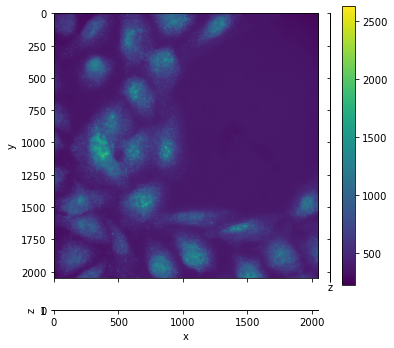

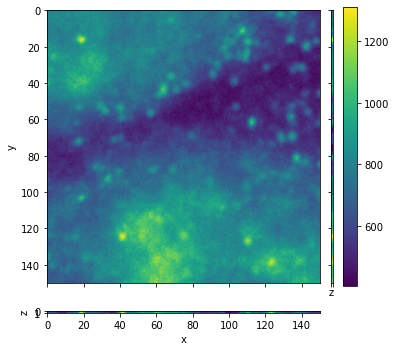

In [79]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])[0][None]
_ = plot_3d_projections(img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img[sl[:]], size=5)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [80]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

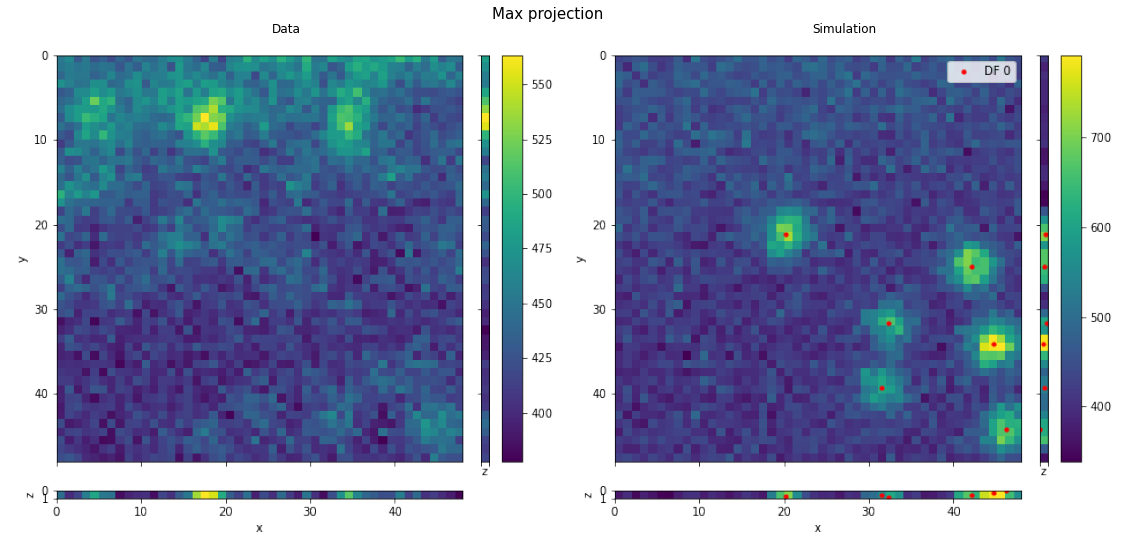

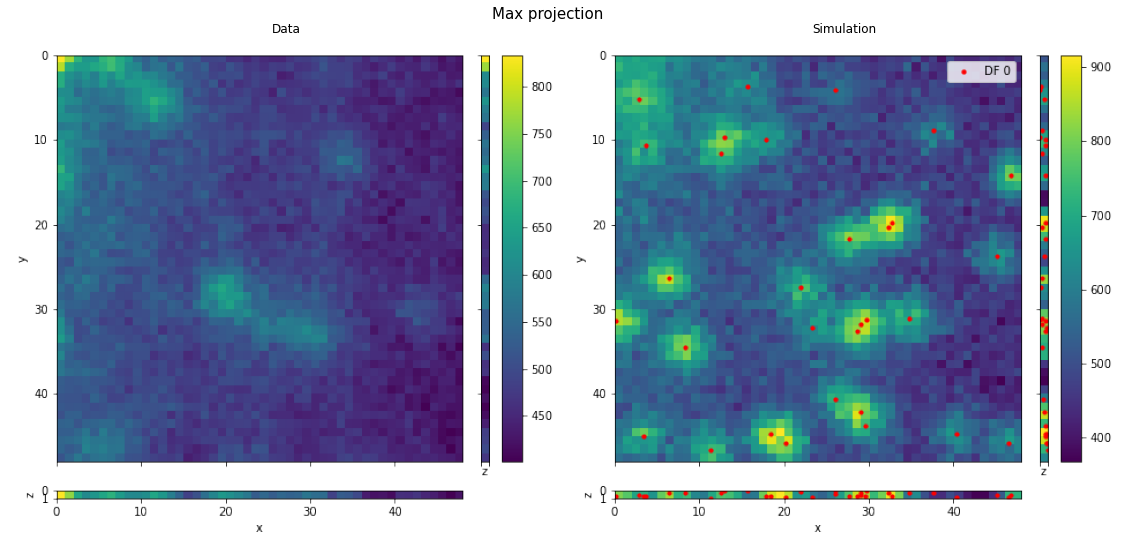

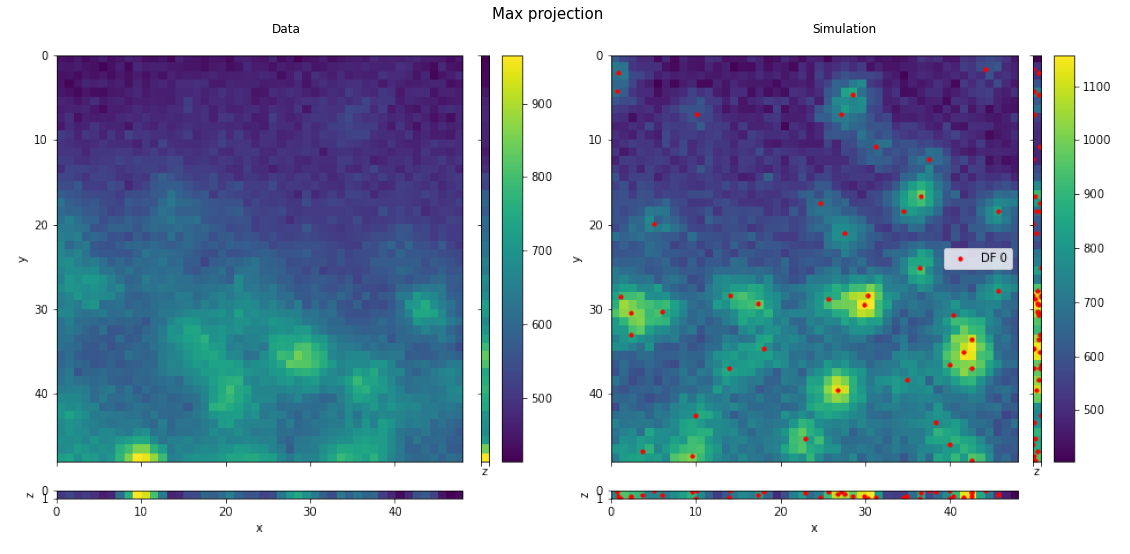

In [81]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=3, channels=cfg.exp_type.channels, n_bits=cfg.exp_type.n_bits)

# Evaluation

In [4]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/MERFISH_starfish_ch0_f2/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_inttest2/enabled:Falsexenabled:Falsexint_loc:0.5/train.yaml')

In [1051]:
# cfg.exp_type.pred_z = False

In [1052]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
# model, post_proc, _, _, _= load_all(cfg)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(micro.psf.psf_volume[0])

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(0., device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>))


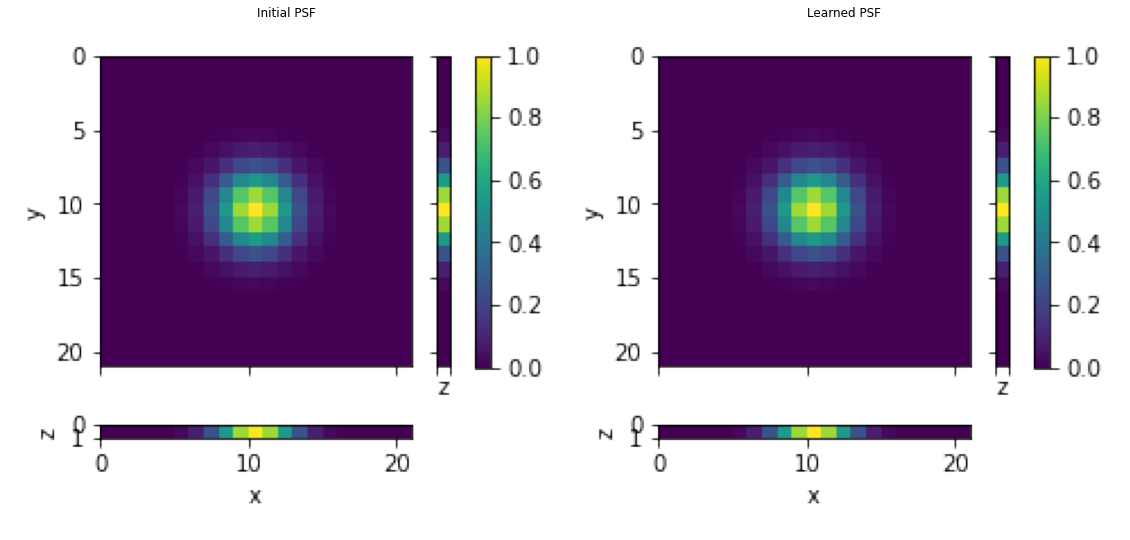

In [1044]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init, proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol, proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

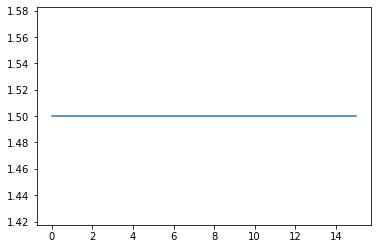

In [1045]:
# plt.subplot(121)
plt.plot(cpu(micro.noise.theta_par*micro.noise.theta_scale))
# plt.plot(ref_theta)

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

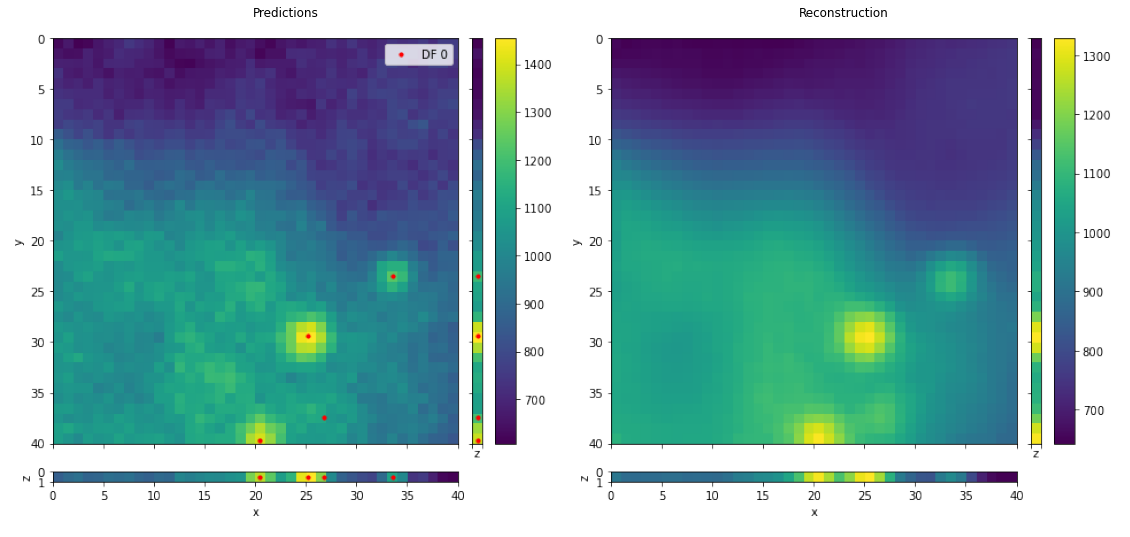

In [1023]:
pred_df, rec, res_dict = eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=40, ret_preds=True)

In [1001]:
locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(res_dict)[:6]
inds = torch.where(ints_3d > 0)[0]
ae_img_3d = micro([l[inds] for l in locations], x_os_3d[inds], y_os_3d[inds], z_os_3d[inds], ints_3d[inds], output_shape)   

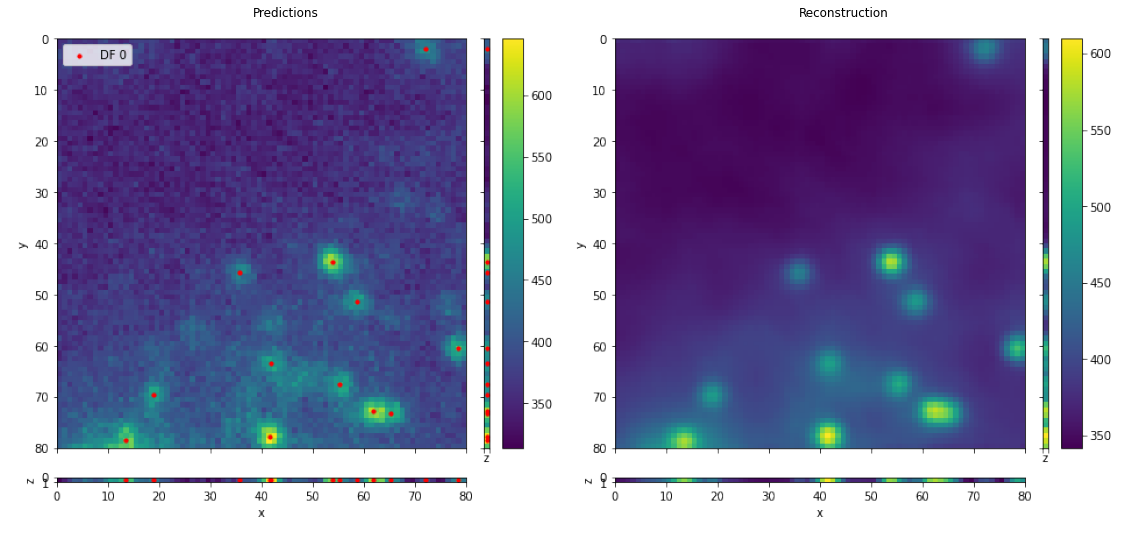

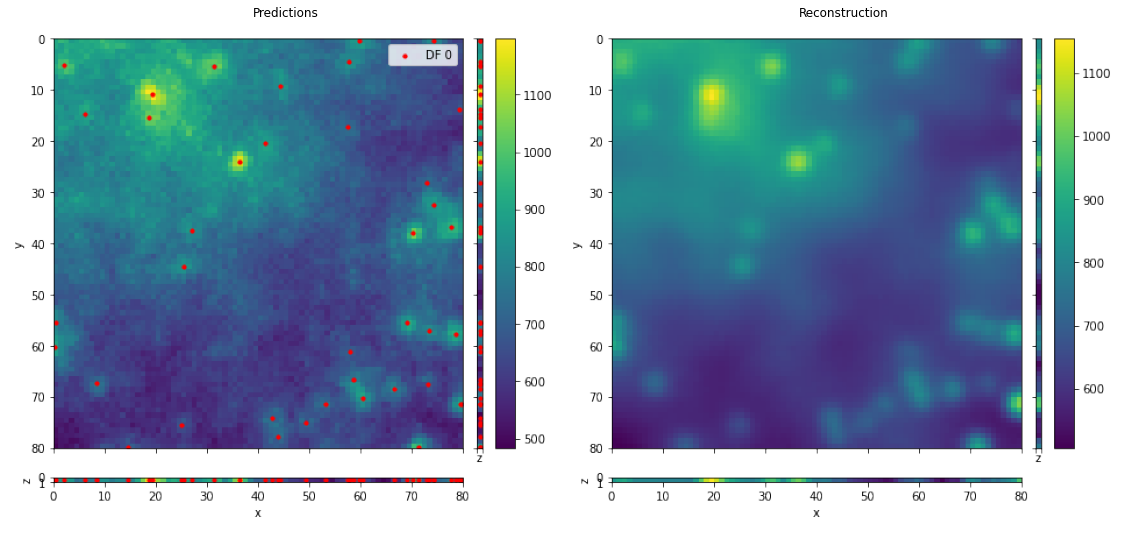

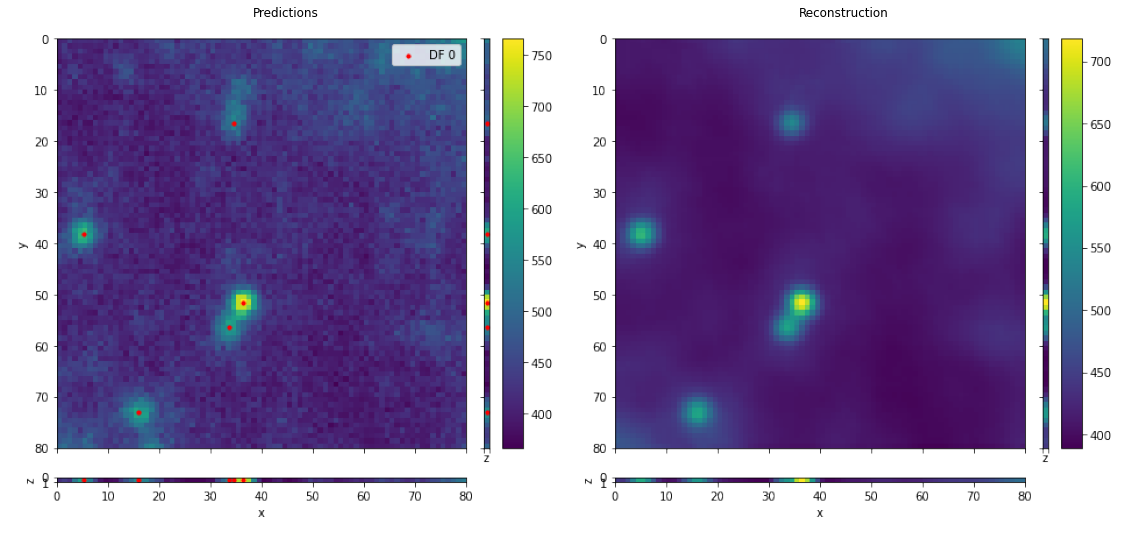

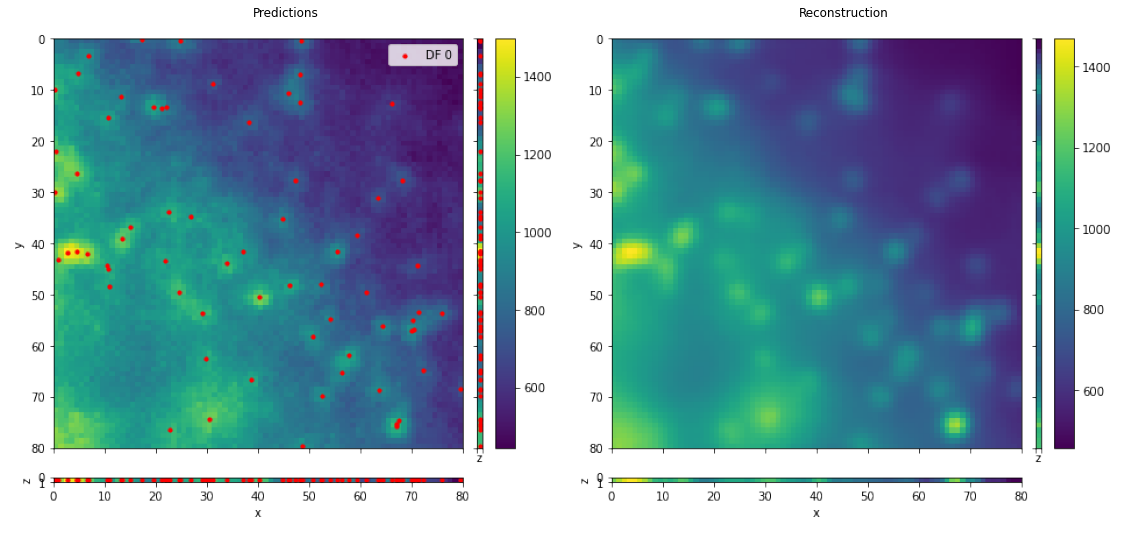

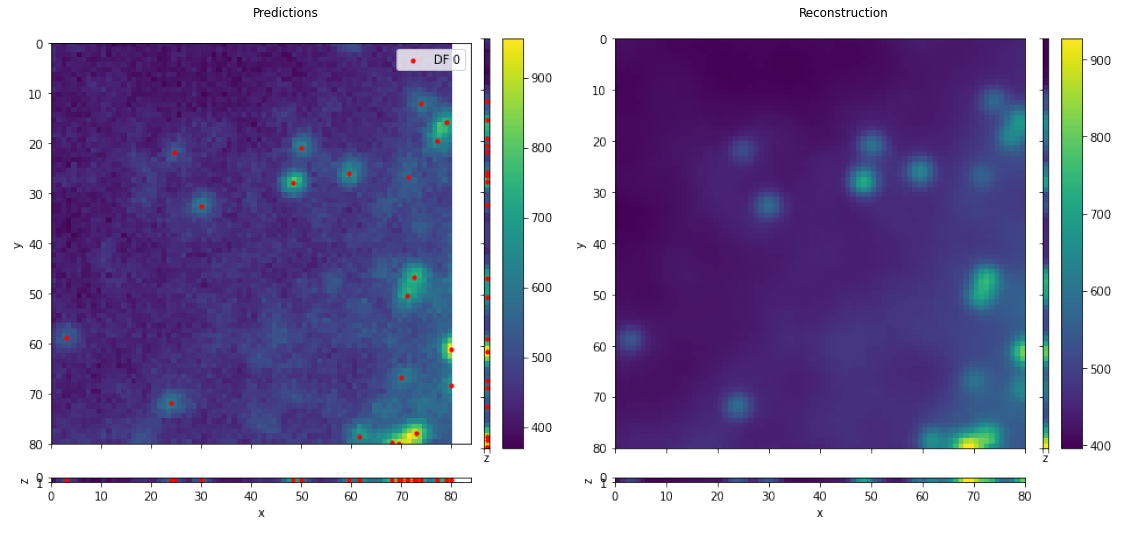

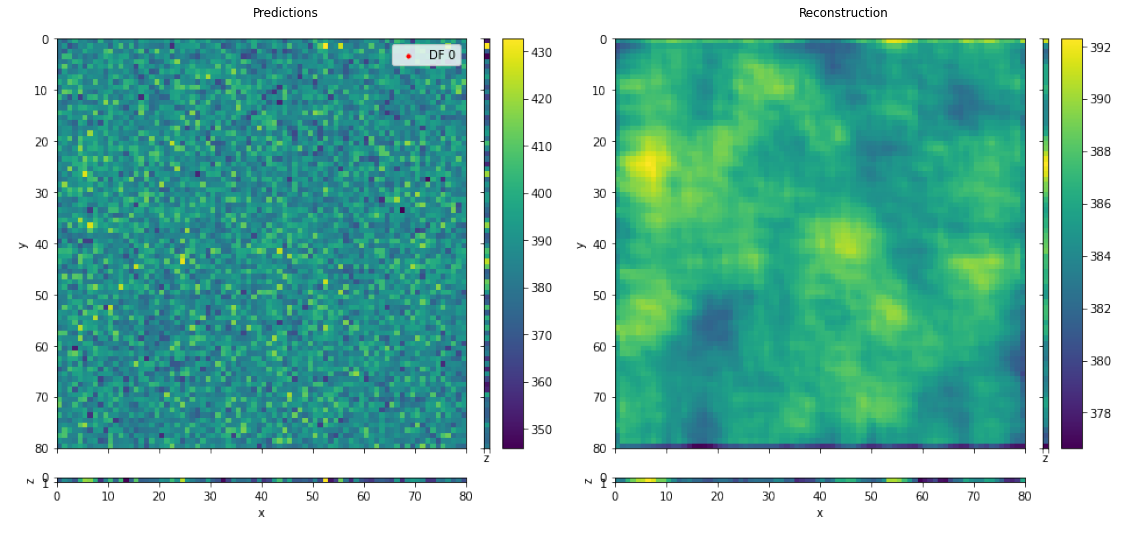

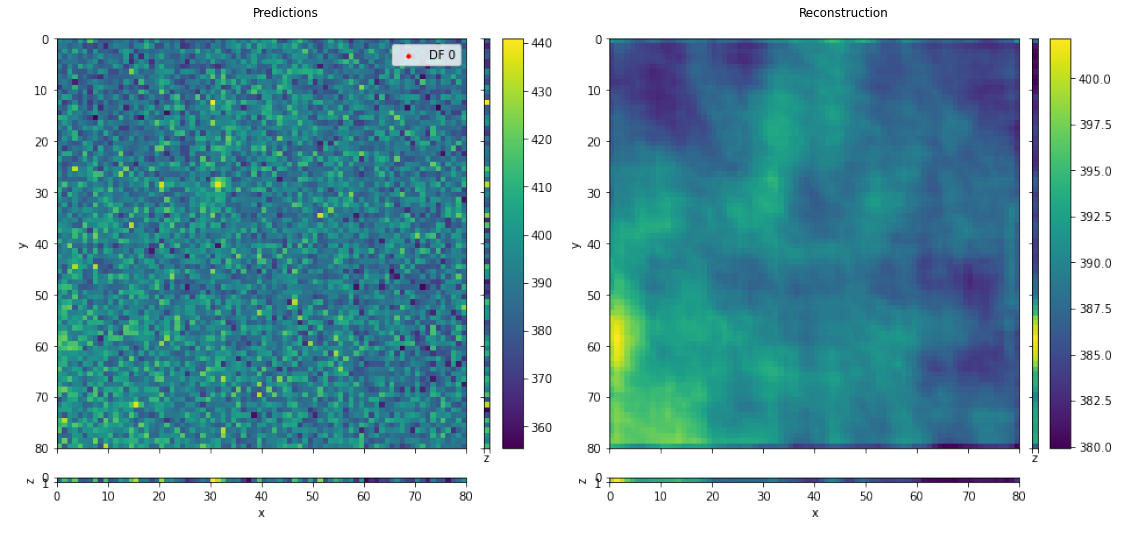

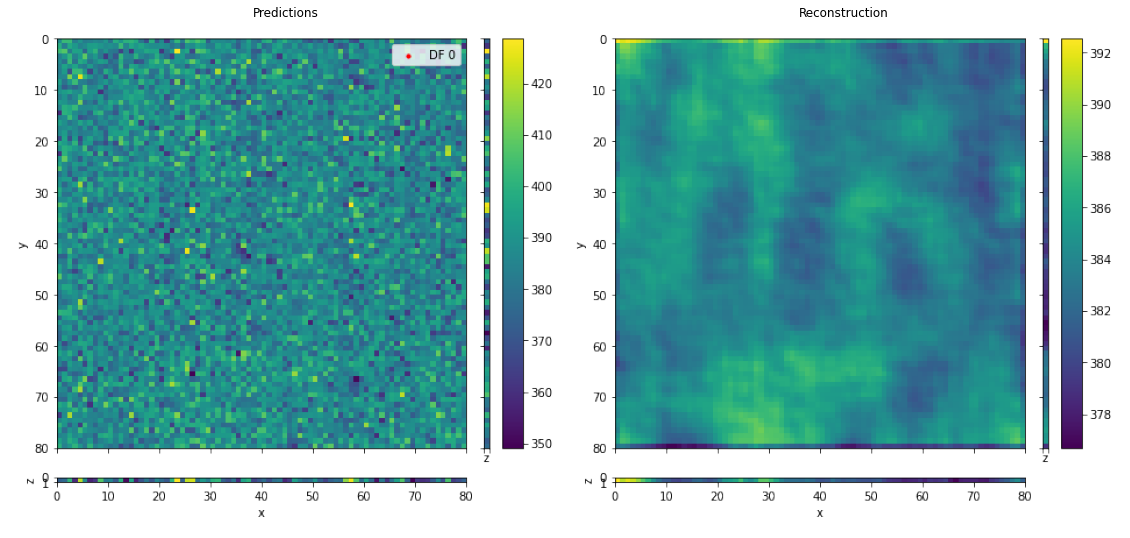

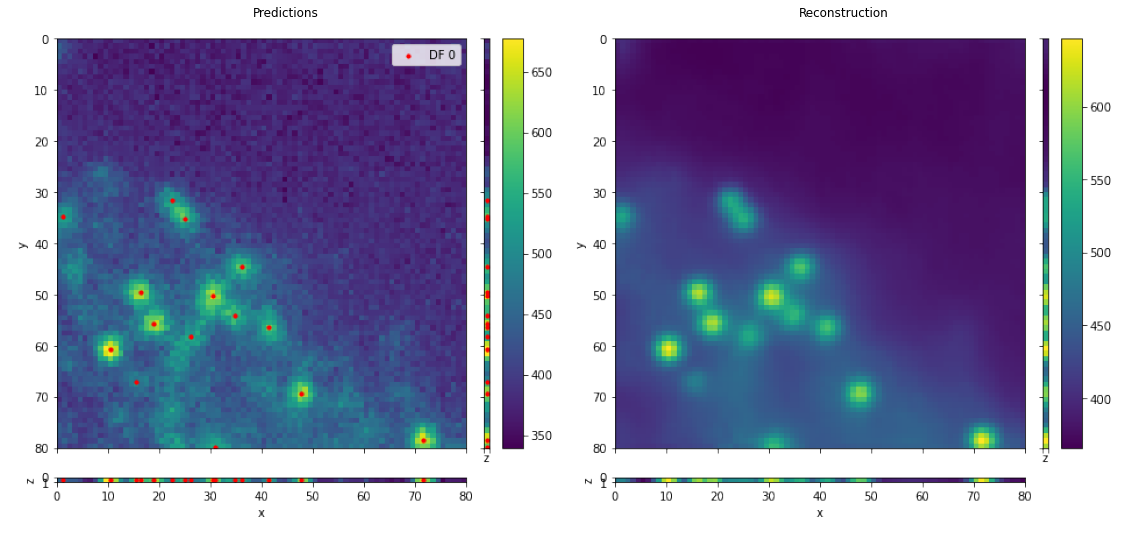

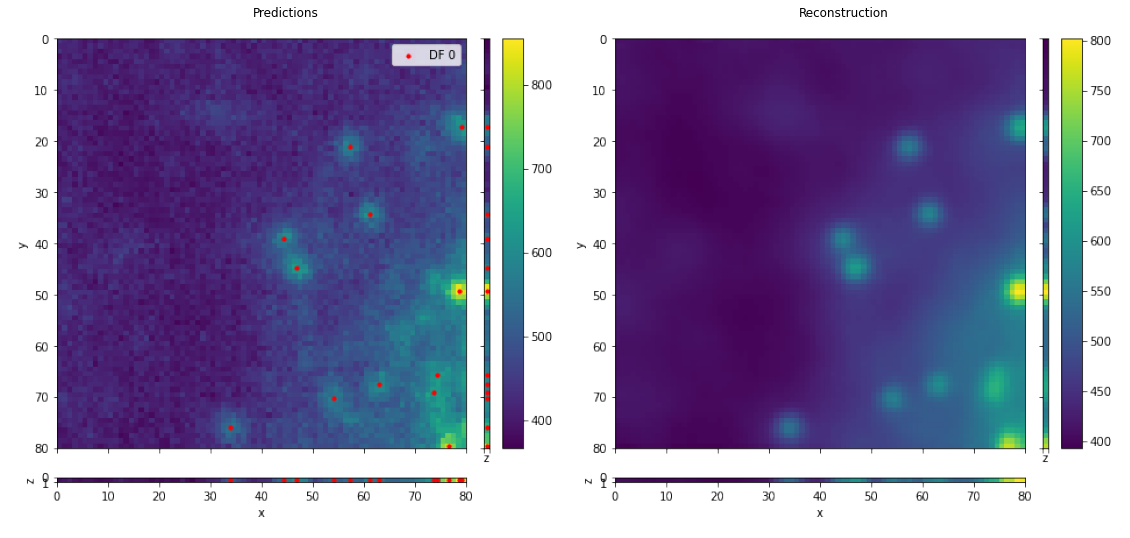

In [1034]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=80)

In [1003]:
# eval_random_crop(decode_dl, model, post_proc, micro, samples=10)

In [1004]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_inttest///enabled:Truexenabled:False/train.yaml')
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [1008]:
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [1009]:
with torch.no_grad():
    x, local_rate, background = next(iter(decode_dl))
    sim_vars = PointProcessUniform(local_rate,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=16, n_bits=4, sim_z=False).sample()
    xsim = micro(*sim_vars[:4], sim_vars[4], sim_vars[5])
    x = micro.noise(xsim, background*0 + background.mean()).sample()

    gt_vars = sim_vars[:-1]
    gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])
    gt_df = gt_df[gt_df['ch_idx'] == 0]

    pred_df, rec, res_dict = get_prediction(model, post_proc, x, micro=micro, cuda=True, return_rec=True, min_int=-100)

Recall: 1.000
Precision: 0.750
Jaccard: 74.999
RMSE_vol: 37.147
Eff_3d: 68.855
FN: 0.0 FP: 4.0
Num. matches: 12.000
Shift: -7.35,-17.53,0.00


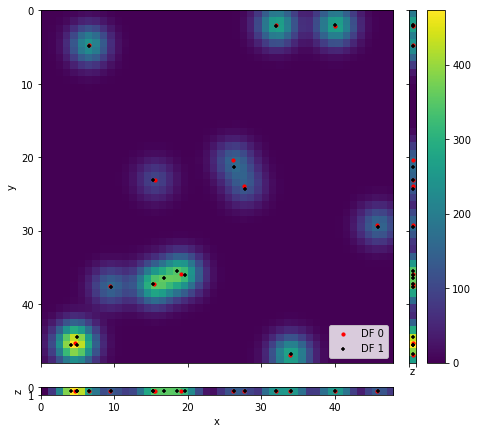

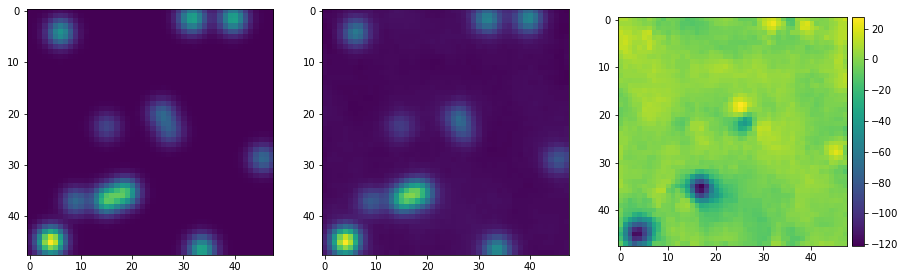

In [1010]:
x_nobg = xsim + background*0 + background.mean()
i = 4

fig, ax = plot_3d_projections(xsim[i,0])
gt_sub = gt_df[(gt_df['ch_idx']==0) & (gt_df['frame_idx'] == i)]
pred_sub = nm_to_px(pred_df)[pred_df['frame_idx'] == i]
scat_3d_projections(ax, [gt_sub, pred_sub])

perf, matches, _ = matching(px_to_nm(gt_sub), px_to_nm(pred_sub), tolerance=500, print_res=True)

plt.figure(figsize=(15,5))

diff = x_nobg-rec

plt.subplot(131)
plt.imshow(cpu(x_nobg)[i,0,0])
plt.subplot(132)
plt.imshow(cpu(rec)[i,0,0])
plt.subplot(133)
im = plt.imshow(cpu(diff)[i,0,0])
add_colorbar(im)

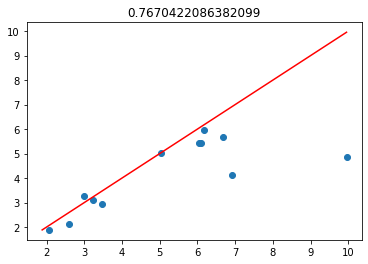

In [1011]:
corr_scatter(matches['int_tar'], matches['int_pred'])

In [1012]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate*1. ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background*0 + background.mean()).sample()

            xsim_col.append(x)
            gt_vars = sim_vars[:-1]
            gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])
            gt_df = gt_df[gt_df['ch_idx'] == 0]
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True, min_int=-100)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches, xrec


In [1013]:
# from decode_fish.funcs.routines import *
xsim, gt = sim_data(decode_dl, 20, micro,model, channels=16, n_bits=4, sim_z=False)
perf, pred_df, matches, rec = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.936
Precision: 0.854
Jaccard: 80.636
RMSE_vol: 67.403
Eff_3d: 61.132
FN: 207.0 FP: 518.0
Num. matches: 3019.000
Shift: -1.24,-0.52,0.00


In [1014]:
print(*model.int_dist.parameters())

Parameter containing:
tensor(4., device='cuda:0', requires_grad=True) Parameter containing:
tensor(1., device='cuda:0', requires_grad=True) Parameter containing:
tensor(0.5000, device='cuda:0', requires_grad=True)


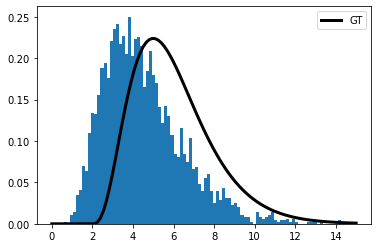

In [1015]:
import scipy.stats as stats  

x = np.linspace(0,15,101)

y = stats.gamma.pdf(x, 4., 2., 1/1.)
plt.plot(x, y, label='GT', linewidth=3, color='black')
plt.hist(gt['int'], bins=np.linspace(0,15,101), density=True)
    
plt.legend()

In [1016]:
# i = 6
# fig, ax = plot_3d_projections(xsim[i,0])
# gt_sub = gt[(gt['ch_idx']==0) & (gt['frame_idx'] == i)]
# pred_sub = nm_to_px(pred_df)[pred_df['frame_idx'] == i]
# scat_3d_projections(ax, [gt_sub, pred_sub])

# perf, matches, _ = matching(px_to_nm(gt_sub), px_to_nm(pred_sub), tolerance=500, print_res=True)

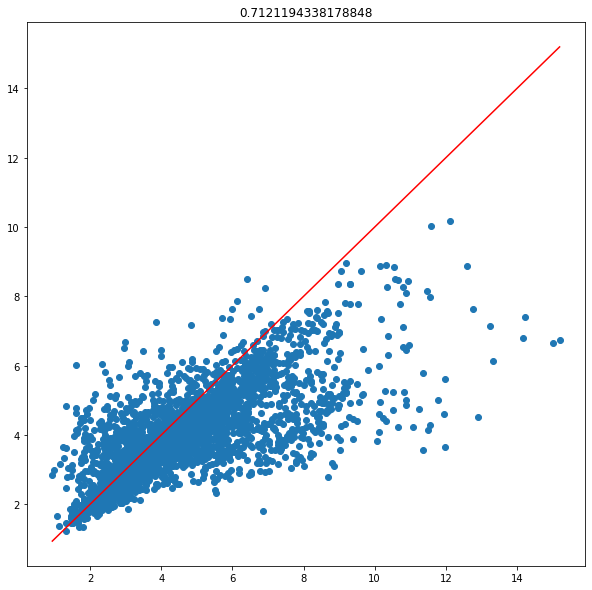

In [1017]:
plt.figure(figsize=(10,10))
corr_scatter(matches['int_tar'], matches['int_pred'])

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [1035]:
from monai.inferers import sliding_window_inference
def predict(model, post_proc, image_paths, window_size=[None,256,256], device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in image_paths:
            print(p.split('/')[-1])
            img = load_tiff_image(p)[None]

            n_chans = img.shape[1]
            print(img.shape)
            z, y, x = img.shape[-3:]
            
            for i in tqdm(range(n_chans)):
                
                inp = torch.roll(img, shifts=[-i], dims=[1])
#                 inp[:,1:] = torch.flip(inp[:,1:], dims=[4])
                output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                # output = model.cpu()(img[None,None])
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                i_df = post_proc.get_df(output, p_si)
                print('N. emitters: ', len(i_df))
                i_df.loc[:,'frame_idx'] = 0
                pred_df = append_emitter_df(pred_df, i_df)
                free_mem()
        return pred_df

In [1053]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

image_paths = sorted(glob.glob(cfg.data_path.image_path))
inf_df = predict(model, post_proc, image_paths, window_size=[None, 256, 256], device='cuda')
inf_df.to_csv(f'../data/results/MERFISH/exp_sf_t_max.csv', index=False)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes
img_stack.tiff


  0%|                                                                     | 0/16 [00:00<?, ?it/s]

torch.Size([1, 16, 1, 2048, 2048])
N. emitters:  12482


  6%|███▊                                                         | 1/16 [00:03<00:51,  3.43s/it]

N. emitters:  14865


 12%|███████▋                                                     | 2/16 [00:07<00:49,  3.56s/it]

N. emitters:  16527


 19%|███████████▍                                                 | 3/16 [00:11<00:51,  3.95s/it]

N. emitters:  14733


 25%|███████████████▎                                             | 4/16 [00:14<00:44,  3.73s/it]

N. emitters:  13582


 31%|███████████████████                                          | 5/16 [00:18<00:40,  3.67s/it]

N. emitters:  15020


 38%|██████████████████████▉                                      | 6/16 [00:21<00:36,  3.62s/it]

N. emitters:  14878


 44%|██████████████████████████▋                                  | 7/16 [00:25<00:32,  3.62s/it]

N. emitters:  22204


 50%|██████████████████████████████▌                              | 8/16 [00:29<00:29,  3.70s/it]

N. emitters:  23108


 56%|██████████████████████████████████▎                          | 9/16 [00:33<00:25,  3.71s/it]

N. emitters:  17125


 62%|█████████████████████████████████████▌                      | 10/16 [00:36<00:22,  3.71s/it]

N. emitters:  20660


 69%|█████████████████████████████████████████▎                  | 11/16 [00:40<00:18,  3.69s/it]

N. emitters:  18385


 75%|█████████████████████████████████████████████               | 12/16 [00:44<00:14,  3.74s/it]

N. emitters:  16751


 81%|████████████████████████████████████████████████▊           | 13/16 [00:48<00:11,  3.70s/it]

N. emitters:  25512


 88%|████████████████████████████████████████████████████▌       | 14/16 [00:51<00:07,  3.77s/it]

N. emitters:  24522


 94%|████████████████████████████████████████████████████████▎   | 15/16 [00:55<00:03,  3.83s/it]

N. emitters:  17982


100%|████████████████████████████████████████████████████████████| 16/16 [00:59<00:00,  3.72s/it]


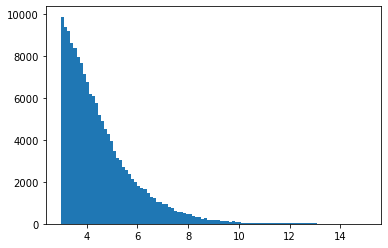

In [1054]:
_ = plt.hist(inf_df['int'], bins=np.linspace(3,15,101))

In [1055]:
# sl = np.s_[:,:,500:1250,1100:1700]
# sl = np.s_[:,:,:,:]
# img = load_tiff_image(image_paths[0])
# for i in range(16):

#     preds_px = nm_to_px(inf_df[inf_df['frame_idx']==(i)])
#     plt.figure(figsize=(25,25))
#     im = plt.imshow(img[i,0][sl[2:]])
#     add_colorbar(im)
#     sub_preds = crop_df(preds_px, sl)
#     plt.scatter(sub_preds['x'],sub_preds['y'], color='red', s=3.5)
#     plt.show()

In [1056]:
inf_df

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig,comb_sig
0,0,0,10030.624023,-40.069401,50.0,0.616795,1.636275,0.268369,49.955494,15.365103,100.0,1.128346
1,1,0,10515.877930,-38.880039,50.0,0.710649,1.594283,0.278484,47.516953,16.620550,100.0,1.119558
2,2,0,15623.184570,-38.628578,50.0,0.843763,1.744576,0.248061,39.356392,17.536453,100.0,1.088873
3,3,0,17218.617188,-36.732559,50.0,0.837575,1.655923,0.274061,36.666962,12.912500,100.0,1.072903
4,4,0,39329.972656,-37.195492,50.0,1.000000,1.946480,0.300813,38.410427,13.889533,100.0,1.080198
...,...,...,...,...,...,...,...,...,...,...,...,...
288331,288331,15,190996.437500,204729.265625,50.0,0.552512,2.501016,0.580236,39.430367,43.459583,100.0,1.159461
288332,288332,15,191300.312500,204734.171875,50.0,0.523607,1.842537,0.453270,46.852898,40.056522,100.0,1.174722
288333,288333,15,196029.734375,204771.328125,50.0,0.808029,4.931407,0.608262,18.751755,17.448524,100.0,1.032283
288334,288334,15,199073.453125,204762.296875,50.0,0.915105,2.169853,0.375099,26.965878,18.041250,100.0,1.051316
